# Project: Adversarial BayesFlow - Experiment 1: MVN means
**Task:** Learn means of a 2-variate Gaussian with unit variance.

# Setup

In [1]:
import os
import sys

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import scipy
import tensorflow as tf
import tensorflow_probability as tfp
import colorednoise as cn
from scipy import stats

import matplotlib.patches as mpatches


from tqdm.notebook import tqdm

sys.path.append(os.path.abspath(os.path.join('../BayesFlow')))

from bayesflow.trainers import ParameterEstimationTrainer
from bayesflow.networks import InvertibleNetwork, InvariantNetwork
from bayesflow.amortizers import SingleModelAmortizer
from bayesflow.models import GenerativeModel
from bayesflow.exceptions import ConfigurationError
from bayesflow.applications.priors import GaussianMeanPrior, TPrior, GaussianMeanCovPrior
from bayesflow.applications.simulators import GaussianMeanSimulator, MultivariateTSimulator, GaussianMeanCovSimulator

from abf_functions import *


RERUN_GRID_EXPERIMENT = True
RERUN_MMD_ERROR_EXPERIMENT = False

In [2]:
plt.rcParams.update({
    "axes.labelsize" : 20,
    "xtick.labelsize" : 16,
    "ytick.labelsize" : 16,
    "text.usetex": True,
    "font.family": "serif",
    "font.serif": ["Times"],
    'text.latex.preamble' : r'\usepackage{{amsmath}}'
})

FILEFORMAT = 'pdf'
DPI = 300

In [3]:
gpu_devices = tf.config.experimental.list_physical_devices('GPU')
for device in gpu_devices: 
    tf.config.experimental.set_memory_growth(device, True)

2021-11-29 20:55:04.264006: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set


In [4]:
D = 2
S_sufficient = 2
S_overcomplete = 4

## Color codes

In [20]:
color_codes = {

    "Prior location" : "goldenrod",
    "Prior scale" : "firebrick",
    "Prior location + scale" : "darkgreen",
    "Simulator" : "yellowgreen",
    "Noise" : "mediumvioletred",
    "No MMS" : "royalblue"
}

## Define sufficient and overcomplete BayesFlow network

In [6]:
# Sufficient

#########

prior = GaussianMeanPrior(D=D)
simulator = GaussianMeanSimulator(D=D)
generative_model = GenerativeModel(prior, simulator)

#########

summary_meta = {
    'n_dense_s1': 2,
    'n_dense_s2': 2,
    'n_dense_s3': 2,
    'n_equiv':    1,
    'dense_s1_args': {'activation': 'relu', 'units': 32},
    'dense_s2_args': {'activation': 'relu', 'units': 32},
    'dense_s3_args': {'activation': 'relu', 'units': 32},
}

class BottleneckSummaryNet(tf.keras.Model):
    def __init__(self, inv_meta={}, n_out=10, activation_out=None):
        super(BottleneckSummaryNet, self).__init__()

        self.invariant_net = InvariantNetwork(inv_meta)
        self.out_layer = tf.keras.layers.Dense(n_out, activation=activation_out)
    
    def __call__(self, x):
        out_inv = self.invariant_net(x)
        out = self.out_layer(out_inv)
        return out


summary_net = BottleneckSummaryNet(inv_meta=summary_meta, 
                                   n_out=S_sufficient,
                                   activation_out=None  # linear
                                  )


inference_meta = {
    'n_coupling_layers': 2,
    's_args': {
        'units': [32, 32, 32],
        'activation': 'elu',
        'initializer': 'glorot_uniform',
    },
    't_args': {
        'units': [32, 32, 32],
        'activation': 'elu',
        'initializer': 'glorot_uniform',
    },
    'n_params': D,
    'alpha': 1.9,
    'permute': True
}

inference_net = InvertibleNetwork(inference_meta)

amortizer = SingleModelAmortizer(inference_net, summary_net)

trainer_sufficient = ParameterEstimationTrainer(amortizer,
                      generative_model,
                      loss=mmd_kl_loss,
                      learning_rate=0.0007,
                      checkpoint_path=f'export_ckpt/mmd/means_{D}D_sufficient',
                      max_to_keep = 1
                     )

2021-11-29 20:55:04.294975: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Networks loaded from export_ckpt/mmd/means_2D_sufficient/ckpt-50


In [7]:
#########

prior = GaussianMeanPrior(D=D)
simulator = GaussianMeanSimulator(D=D)
generative_model = GenerativeModel(prior, simulator)

#########

summary_meta = {
    'n_dense_s1': 2,
    'n_dense_s2': 2,
    'n_dense_s3': 2,
    'n_equiv':    1,
    'dense_s1_args': {'activation': 'relu', 'units': 32},
    'dense_s2_args': {'activation': 'relu', 'units': 32},
    'dense_s3_args': {'activation': 'relu', 'units': 32},
}

class BottleneckSummaryNet(tf.keras.Model):
    def __init__(self, inv_meta={}, n_out=10, activation_out=None):
        super(BottleneckSummaryNet, self).__init__()

        self.invariant_net = InvariantNetwork(inv_meta)
        self.out_layer = tf.keras.layers.Dense(n_out, activation=activation_out)
    
    def __call__(self, x):
        out_inv = self.invariant_net(x)
        out = self.out_layer(out_inv)
        return out


summary_net = BottleneckSummaryNet(inv_meta=summary_meta, 
                                   n_out=S_overcomplete,
                                   activation_out=None  # linear
                                  )


inference_meta = {
    'n_coupling_layers': 2,
    's_args': {
        'units': [32, 32, 32],
        'activation': 'elu',
        'initializer': 'glorot_uniform',
    },
    't_args': {
        'units': [32, 32, 32],
        'activation': 'elu',
        'initializer': 'glorot_uniform',
    },
    'n_params': D,
    'alpha': 1.9,
    'permute': True
}

inference_net = InvertibleNetwork(inference_meta)

amortizer = SingleModelAmortizer(inference_net, summary_net)

trainer_overcomplete = ParameterEstimationTrainer(amortizer,
                      generative_model,
                      loss=mmd_kl_loss,
                      learning_rate=0.0007,
                      checkpoint_path=f'export_ckpt/mmd/means_{D}D_overcomplete',
                      max_to_keep = 1
                     )

Networks loaded from export_ckpt/mmd/means_2D_overcomplete/ckpt-50


## Converge BayesFlow networks

In [ ]:
#losses = trainer_sufficient.train_rounds(epochs=10, rounds=5, sim_per_round=10000, batch_size=128, n_obs=100)

In [ ]:
# losses = trainer_overcomplete.train_rounds(epochs=10, rounds=5, sim_per_round=10000, batch_size=128, n_obs=100)

# Performance: Recover analytic Posterior

In [8]:
def calculate_analytic_posterior(prior, simulator, x):
    n_sim, n_obs, D = x.shape
    
    # Set up variables
    x_bar = np.mean(x, axis=1)                 # empirical mean
    sigma_0 = np.eye(D) * prior.mu_scale       # mu prior covariance
    sigma_0_inv = np.linalg.inv(sigma_0)       # inverse mu prior covariance
    mu_0 = np.ones((D, 1)) * prior.mu_mean     # mu prior mean
    sigma = simulator.sigma                    # likelihood covariance
    sigma_inv = np.linalg.inv(sigma)           # inverse likelihood covariance
    
    mu_posterior_covariance = np.stack([np.linalg.inv(sigma_0_inv + n_obs*sigma_inv)] * n_sim)
    
    mu_posterior_mean = mu_posterior_covariance @ (sigma_0_inv @ mu_0 + n_obs * (sigma_inv @ x_bar[..., np.newaxis]))   
    mu_posterior_mean = mu_posterior_mean.reshape(n_sim, D)

    return mu_posterior_mean, mu_posterior_covariance

In [9]:
def adversarial_diagnostics(trainer, generative_model, theta=None, x=None, filename=None):
    theta, x = generative_model(200, 100) if theta is None and x is None else (theta, x)
    param_samples = trainer.network.sample(x, n_samples=200)
    param_means = param_samples.mean(axis=0)

    # analytic posteriors
    print("\n\nBayesFlow (x) vs. analytic posterior means (y) -- Recovery of analytic posterior means")
    prior = trainer.generative_model.prior.__self__
    simulator = trainer.generative_model.simulator
    posterior_means, posterior_covariances = calculate_analytic_posterior(prior, simulator, x)
    posterior_variances = posterior_covariances.diagonal(axis1=1, axis2=2)
    
    true_vs_estimated(posterior_means, param_means, [r'$\mu_%i$'%i for i in range(1, D+1)], figsize=(8,4), dpi=DPI,
                          filename=f"{filename}_true_analytic.{FILEFORMAT}")

### Baseline: $\mathcal{M}_{obs} = \mathcal{M}^*$ 

In [ ]:
prior = GaussianMeanPrior(D=D, mu_mean=0, mu_scale=1)
simulator = GaussianMeanSimulator(D=D)
generative_model = GenerativeModel(prior, simulator)
theta, x = generative_model(200,100)

adversarial_diagnostics(trainer_sufficient, generative_model, 
                        #print_plots=True,
                       filename=f"plots/abf_mvn_means_sufficient_baseline")

In [ ]:
prior = GaussianMeanPrior(D=D, mu_mean=0, mu_scale=1)
simulator = GaussianMeanSimulator(D=D)
generative_model = GenerativeModel(prior, simulator)
theta, x = generative_model(200,100)

adversarial_diagnostics(trainer_overcomplete, generative_model, 
                        #print_plots=True,
                       filename=f"plots/abf_mvn_means_overcomplete_baseline")

## Wrong Prior
The prior over the multivariate Gaussian's means is Gaussian: $\mu\sim\mathcal{N}(\mu|\mu_0, \Sigma_0)$

- Wrong (free) prior location and scale: $\mu\sim\mathcal{N}(\mu_0, \tau_0\cdot\mathbb{I})$

In [ ]:
mu_0 = 5.0
tau_0 = 2.5

prior = GaussianMeanPrior(D=D, mu_mean=mu_0, mu_scale=tau_0)
simulator = GaussianMeanSimulator(D=D)
generative_model = GenerativeModel(prior, simulator)
theta, x = generative_model(200,100)

adversarial_diagnostics(trainer_sufficient, generative_model,  
                        #print_plots=True,
                       filename=f"plots/abf_mvn_means_sufficient_prior")

In [ ]:
mu_0 = 5.0
tau_0 = 2.5

prior = GaussianMeanPrior(D=D, mu_mean=mu_0, mu_scale=tau_0)
simulator = GaussianMeanSimulator(D=D)
generative_model = GenerativeModel(prior, simulator)
theta, x = generative_model(200,100)

adversarial_diagnostics(trainer_overcomplete, generative_model,  
                        #print_plots=True,
                       filename=f"plots/abf_mvn_means_overcomplete_prior")

## (A2) Wrong Likelihood

$\boldsymbol{x}_k\sim \mathcal{N}(\boldsymbol{\mu}, \tau\cdot\mathbb{I})$

In [ ]:
tau = 10.0

prior = GaussianMeanPrior(D=D, mu_mean=0, mu_scale=1)
simulator = GaussianMeanSimulator(D=D, s = tau)
generative_model = GenerativeModel(prior, simulator)
theta, x = generative_model(200,100)

adversarial_diagnostics(trainer_sufficient, generative_model,  
                        #print_plots=True,
                       filename=f"plots/abf_mvn_means_sufficient_likelihood")

In [ ]:
tau = 10.0
prior = GaussianMeanPrior(D=D, mu_mean=0, mu_scale=1)
simulator = GaussianMeanSimulator(D=D, s = tau)
generative_model = GenerativeModel(prior, simulator)
theta, x = generative_model(200,100)

adversarial_diagnostics(trainer_overcomplete, generative_model,  
                        #print_plots=True,
                       filename=f"plots/abf_mvn_means_overcomplete_likelihood")

## (A3) Noise
$\mathbf{x}_k = \mathbf{x}_k + \xi$

In this scenario, the contamination $\xi$ is *stable noise* and added to the data $x$. The contaminated data is then normalized to obtain the variance of $x$ again.

In [ ]:
prior = GaussianMeanPrior(D=D, mu_mean=0, mu_scale=1)
simulator = GaussianMeanSimulator(D=D)

generative_model = GenerativeModel(prior, simulator)
theta, x = generative_model(200, 100)

lamda = 0.5  # contribution of contamination xi 

x = noisify_x(x, lamda=lamda)

adversarial_diagnostics(trainer_sufficient, generative_model=None, theta=theta, x=x,  
                        #print_plots=True,
                       filename=f"plots/abf_mvn_means_sufficient_noise")

In [ ]:
prior = GaussianMeanPrior(D=D, mu_mean=0, mu_scale=1)
simulator = GaussianMeanSimulator(D=D)

generative_model = GenerativeModel(prior, simulator)
theta, x = generative_model(200, 100)

lamda = 0.5  # contribution of contamination xi 

x = noisify_x(x, lamda=lamda)

adversarial_diagnostics(trainer_overcomplete, generative_model=None, theta=theta, x=x,  
                        #print_plots=True,
                       filename=f"plots/abf_mvn_means_overcomplete_noise")

# Summary space: MMD contour plots

## $\widehat{MMD}^2_u$ w.r.t. prior (location and scale factor)

In [ ]:
# RERUN_GRID_EXPERIMENT = True

In [ ]:
n_loc = 101
n_scale = 101
prior_loc = np.linspace(-6.0, 6.0, num = n_loc)
prior_scale = np.linspace(0.10, 5.90, num = n_scale)
P1, P2 = np.meshgrid(prior_loc, prior_scale)

if RERUN_GRID_EXPERIMENT:
    _, x_star = trainer_sufficient._forward_inference(200, 100)
    s_star = np.array(trainer_sufficient.network.summary_net(x_star))

    MMD = np.zeros((n_scale, n_loc))
    for i in tqdm(range(n_scale)):
        for j in range(n_loc):
            p1 = P1[i, j]
            p2 = P2[i, j]
            prior = GaussianMeanPrior(D=D, mu_mean=p1, mu_scale=p2)
            simulator = GaussianMeanSimulator(D=D)
            generative_model = GenerativeModel(prior, simulator)
            _, x_o = generative_model(200, 100)
            s_o = np.array(trainer_sufficient.network.summary_net(x_o))
            MMD[i, j] = float(maximum_mean_discrepancy(s_o, s_star, unbiased=True))
    np.save(f"data/MMD_grid_experiments/MVN_MMD_grid_sufficient_prior.npy", MMD)
    
MMD = np.load(f"data/MMD_grid_experiments/MVN_MMD_grid_sufficient_prior.npy")
plt.figure(figsize=(10, 5))
plt.pcolor(P1, P2, MMD, shading="nearest", rasterized=True)
plt.xlabel(r"$\mu_0$")
plt.ylabel(r"$\tau_0$ (scale factor of $\Sigma_0$)")
plt.axhline(y=1.0, linestyle="--", color="lightgreen", alpha=.80)
plt.axvline(x=0.0, linestyle="--", color="lightgreen", alpha=.80)

plt.xticks([-5, 0, 5])

plt.plot(5, 2.5, linewidth=10, alpha=1.0, 
         marker="o", markersize=20, markeredgewidth=5.0, markeredgecolor="white", markerfacecolor = color_codes["Prior location + scale"]
        )
plt.plot(0, 2.5, linewidth=10, alpha=1.0, 
         marker="o", markersize=20, markeredgewidth=5.0, markeredgecolor="white", markerfacecolor = color_codes["Prior scale"]
        )
plt.plot(5, 1, linewidth=10, alpha=1.0, 
         marker="o", markersize=20, markeredgewidth=5.0, markeredgecolor="white", markerfacecolor = color_codes["Prior location"]
        )

plt.plot(0, 1, linewidth=10, alpha=1.0, 
         marker="o", markersize=20, markeredgewidth=5.0, markeredgecolor="white", markerfacecolor = color_codes["No MMS"]
        )



cbar = plt.colorbar()
cbar.ax.set_xlabel(r"$\widehat{\mathrm{MMD}}^2_u$")
plt.savefig(f"plots/abf_mvn_means_sufficient_mmd_grid_prior.{FILEFORMAT}", bbox_inches="tight", dpi=DPI)

In [ ]:
n_loc = 101
n_scale = 101
prior_loc = np.linspace(-6.0, 6.0, num = n_loc)
prior_scale = np.linspace(0.10, 5.90, num = n_scale)
P1, P2 = np.meshgrid(prior_loc, prior_scale)

if RERUN_GRID_EXPERIMENT:
    _, x_star = trainer_overcomplete._forward_inference(200, 100)
    s_star = np.array(trainer_overcomplete.network.summary_net(x_star))

    MMD = np.zeros((n_scale, n_loc))
    for i in tqdm(range(n_scale)):
        for j in range(n_loc):
            p1 = P1[i, j]
            p2 = P2[i, j]
            prior = GaussianMeanPrior(D=D, mu_mean=p1, mu_scale=p2)
            simulator = GaussianMeanSimulator(D=D)
            generative_model = GenerativeModel(prior, simulator)
            _, x_o = generative_model(200, 100)
            s_o = np.array(trainer_overcomplete.network.summary_net(x_o))
            MMD[i, j] = float(maximum_mean_discrepancy(s_o, s_star, unbiased=True))
    np.save(f"data/MMD_grid_experiments/MVN_MMD_grid_overcomplete_prior.npy", MMD)
    
MMD = np.load(f"data/MMD_grid_experiments/MVN_MMD_grid_overcomplete_prior.npy")
plt.figure(figsize=(10, 5))
plt.pcolor(P1, P2, MMD, shading="nearest", rasterized=True)
plt.xlabel(r"$\mu_0$")
plt.ylabel(r"$\tau_0$ (scale factor of $\Sigma_0$)")
plt.axhline(y=1.0, linestyle="--", color="lightgreen", alpha=.80)
plt.axvline(x=0.0, linestyle="--", color="lightgreen", alpha=.80)

plt.xticks([-5, 0, 5])

plt.plot(5, 2.5, linewidth=10, alpha=1.0, 
         marker="o", markersize=20, markeredgewidth=5.0, markeredgecolor="white", markerfacecolor = color_codes["Prior location + scale"]
        )
plt.plot(0, 2.5, linewidth=10, alpha=1.0, 
         marker="o", markersize=20, markeredgewidth=5.0, markeredgecolor="white", markerfacecolor = color_codes["Prior scale"]
        )
plt.plot(5, 1, linewidth=10, alpha=1.0, 
         marker="o", markersize=20, markeredgewidth=5.0, markeredgecolor="white", markerfacecolor = color_codes["Prior location"]
        )

plt.plot(0, 1, linewidth=10, alpha=1.0, 
         marker="o", markersize=20, markeredgewidth=5.0, markeredgecolor="white", markerfacecolor = color_codes["No MMS"]
        )

cbar = plt.colorbar()
cbar.ax.set_xlabel(r"$\widehat{\mathrm{MMD}}^2_u$")
plt.savefig(f"plots/abf_mvn_means_overcomplete_mmd_grid_prior.{FILEFORMAT}", bbox_inches="tight", dpi=DPI)

## $\widehat{MMD}^2_u$ w.r.t. Simulator and noise

In [ ]:
from matplotlib.markers import MarkerStyle

In [ ]:
RERUN_GRID_EXPERIMENT=False

In [ ]:
n_tau = 101
n_lamda = 101
tau_list = np.linspace(1.0, 21.0, num = n_tau)
lamda_list = np.linspace(0.0, 1.0, num = n_lamda)

tau_grid, lamda_grid = np.meshgrid(tau_list, lamda_list)

if RERUN_GRID_EXPERIMENT:
    _, x = trainer_sufficient._forward_inference(200, 100)
    z_psi = np.array(trainer_sufficient.network.summary_net(x))

    MMD = np.zeros((n_lamda, n_tau))
    for i in tqdm(range(n_lamda)):
        for j in range(n_tau):
            tau = tau_grid[i, j]
            lamda = lamda_grid[i, j]
            prior = GaussianMeanPrior(D=D, mu_mean=0.0, mu_scale=1.0)
            simulator = GaussianMeanSimulator(D=D, s=tau)
            generative_model = GenerativeModel(prior, simulator)
            _, x_o = generative_model(200, 100)

            x_o = noisify_x(x_o, lamda = lamda,
                      noise_sampler = partial(beta_noise_sampler, a=2, b=5, tau=tau))

            s_o = np.array(trainer_sufficient.network.summary_net(x_o))
            MMD[i, j] = float(maximum_mean_discrepancy(s_o, z_psi, unbiased=True))
    np.save(f"data/MMD_grid_experiments/MVN_MMD_grid_sufficient_likelihood_noise.npy", MMD)
    


MMD = np.load(f"data/MMD_grid_experiments/MVN_MMD_grid_sufficient_likelihood_noise.npy")
plt.figure(figsize=(10, 5))
plt.pcolor(lamda_list, tau_list, MMD.T, shading="nearest", rasterized=True, vmin=0, vmax=9)

plt.xlabel(r"$\lambda$ (noise fraction)")
plt.ylabel(r"$\tau$ (scale factor of $\Sigma$)")

plt.axvline(x=0.0, linestyle="--", color="lightgreen", alpha=1.00, linewidth=2)
plt.axhline(y=1.0, linestyle="--", color="lightgreen", alpha=1.00, linewidth=2)


plt.plot(0.5, 1, linewidth=10, alpha=1.0, 
         marker="o", markersize=20, markeredgewidth=5.0, markeredgecolor="white", markerfacecolor = color_codes["Noise"]
        )
plt.plot(0, 1, linewidth=10, alpha=1.0, 
         marker="o", markersize=20, markeredgewidth=5.0, markeredgecolor="white", markerfacecolor = color_codes["No MMS"]
        )
plt.plot(0, 10, linewidth=10, alpha=1.0, 
         marker=MarkerStyle("o"), markersize=20, markeredgewidth=5.0, markeredgecolor="white", markerfacecolor = color_codes["Simulator"]
        )


plt.xlim(-0.03)
plt.ylim(0)

cbar = plt.colorbar()
cbar.ax.set_xlabel(r"$\widehat{\mathrm{MMD}}^2_u$")

plt.savefig(f"plots/abf_mvn_means_sufficient_mmd_grid_likelihood_noise.{FILEFORMAT}", bbox_inches="tight", dpi=DPI)

In [ ]:
n_tau = 101
n_lamda = 101
tau_list = np.linspace(1.0, 21.0, num = n_tau)
lamda_list = np.linspace(0.0, 1.0, num = n_lamda)

tau_grid, lamda_grid = np.meshgrid(tau_list, lamda_list)

if RERUN_GRID_EXPERIMENT:
    _, x = trainer_overcomplete._forward_inference(200, 100)
    z_psi = np.array(trainer_overcomplete.network.summary_net(x))

    MMD = np.zeros((n_lamda, n_tau))
    for i in tqdm(range(n_lamda)):
        for j in range(n_tau):
            tau = tau_grid[i, j]
            lamda = lamda_grid[i, j]
            prior = GaussianMeanPrior(D=D, mu_mean=0.0, mu_scale=1.0)
            simulator = GaussianMeanSimulator(D=D, s=tau)
            generative_model = GenerativeModel(prior, simulator)
            _, x_o = generative_model(200, 100)

            x_o = noisify_x(x_o, lamda = lamda,
                      noise_sampler = partial(beta_noise_sampler, a=2, b=5, tau=tau))
            
            s_o = np.array(trainer_overcomplete.network.summary_net(x_o))
            MMD[i, j] = float(maximum_mean_discrepancy(s_o, z_psi, unbiased=True))
    np.save(f"data/MMD_grid_experiments/MVN_MMD_grid_overcomplete_likelihood_noise.npy", MMD)
    


MMD = np.load(f"data/MMD_grid_experiments/MVN_MMD_grid_overcomplete_likelihood_noise.npy")
plt.figure(figsize=(10, 5))
plt.pcolor(lamda_list, tau_list, MMD.T, shading="nearest", rasterized=True, vmin=0, vmax=9)

plt.xlabel(r"$\lambda$ (noise fraction)")
plt.ylabel(r"$\tau$ (scale factor of $\Sigma$)")

plt.axvline(x=0.0, linestyle="--", color="lightgreen", alpha=1.00, linewidth=2)
plt.axhline(y=1.0, linestyle="--", color="lightgreen", alpha=1.00, linewidth=2)


plt.plot(0.5, 1, linewidth=10, alpha=1.0, 
         marker="o", markersize=20, markeredgewidth=5.0, markeredgecolor="white", markerfacecolor = color_codes["Noise"]
        )
plt.plot(0, 1, linewidth=10, alpha=1.0, 
         marker="o", markersize=20, markeredgewidth=5.0, markeredgecolor="white", markerfacecolor = color_codes["No MMS"]
        )
plt.plot(0, 10, linewidth=10, alpha=1.0, 
         marker=MarkerStyle("o"), markersize=20, markeredgewidth=5.0, markeredgecolor="white", markerfacecolor = color_codes["Simulator"]
        )

plt.xlim(-0.03)
plt.ylim(0)

cbar = plt.colorbar()
cbar.ax.set_xlabel(r"$\widehat{\mathrm{MMD}}^2_u$")

plt.savefig(f"plots/abf_mvn_means_overcomplete_mmd_grid_likelihood_noise.{FILEFORMAT}", bbox_inches="tight", dpi=DPI)

# Summary Space Pairplots

## Pairplot sufficient

In [ ]:
n_sim = 10000

# No MMS
_, x_no_MMS = GenerativeModel(
    GaussianMeanPrior(D=D, mu_mean=0, mu_scale=1), 
    GaussianMeanSimulator(D=D))(n_sim, 100)

# Prior location MMS
_, x_prior_location_MMS = GenerativeModel(
    GaussianMeanPrior(D=D, mu_mean=5, mu_scale=1), 
    GaussianMeanSimulator(D=D))(n_sim, 100)

# Prior scale MMS
_, x_prior_scale_MMS = GenerativeModel(
    GaussianMeanPrior(D=D, mu_mean=0, mu_scale=2.5), 
    GaussianMeanSimulator(D=D))(n_sim, 100)

# Prior location and scale MMS
_, x_prior_location_scale_MMS = GenerativeModel(
    GaussianMeanPrior(D=D, mu_mean=5, mu_scale=2.5), 
    GaussianMeanSimulator(D=D))(n_sim, 100)


s_no_MMS = np.array(trainer_sufficient.network.summary_net(x_no_MMS))
s_prior_location_MMS = np.array(trainer_sufficient.network.summary_net(x_prior_location_MMS))
s_prior_scale_MMS = np.array(trainer_sufficient.network.summary_net(x_prior_scale_MMS))
s_prior_location_scale_MMS = np.array(trainer_sufficient.network.summary_net(x_prior_location_scale_MMS))

In [ ]:
TASK_NAMES = ['Prior location', 'Prior scale', 'Prior location + scale', 'No MMS']
S_ALL = [s_prior_location_MMS, s_prior_scale_MMS, s_prior_location_scale_MMS, s_no_MMS]
DF = (pd.DataFrame(s, columns=[r'$s_{%i}$'%i for i in range(1, S_sufficient+1)]) for s in S_ALL)

df = pd.concat(DF,
              keys=TASK_NAMES,
              names=['MMS', None]
              ).reset_index(level=0)

In [ ]:
def plot_subset(x, y, hue, mask, **kws):
    sns.kdeplot(x=x[mask], y=y[mask], hue=hue[mask], fill=True, levels=10, antialiased=True, **kws)

g = sns.PairGrid(df, hue="MMS", height=3, palette=[color_codes[task_name] for task_name in TASK_NAMES] )

g.map_diag(sns.kdeplot)

g.map_lower(plot_subset, mask= 
            (
                (df["MMS"] == 'Prior location') |
                (df["MMS"] == 'Prior scale') |
                (df["MMS"] == 'No MMS')
           )
           )


g.map_upper(plot_subset, mask= 
            (
                (df["MMS"] == 'Prior location + scale') |
                (df["MMS"] == 'No MMS')
           )
           )

#handles = [mpatches.Patch(facecolor=color_codes["No MMS"], label="No MMS"),
#           mpatches.Patch(facecolor=color_codes["Prior location"], label="Prior location"),
#           mpatches.Patch(facecolor=color_codes["Prior scale"], label=r"Prior scale"),
#           mpatches.Patch(facecolor=color_codes["Prior location + scale"], label="Prior location + scale")
#           ]
#plt.legend(handles=handles, loc="upper center", ncol=4, bbox_to_anchor=(0, -1.3), title="", fontsize=20)

absmax = np.ceil(np.abs(df.iloc[:, 1:].values).max())
ticks = np.arange(-100, 100, 5)
ticks = ticks[(ticks>-absmax) & (ticks<absmax)]

for ax in g.axes.flatten():
    ax.set_xlim(-absmax, absmax)
    ax.set_ylim(-absmax, absmax)
    
    #ax.set_xticks(ticks)
    #ax.set_yticks(ticks)
    

plt.savefig(f"plots/abf_mvn_means_sufficient_pairplot.{FILEFORMAT}", bbox_inches="tight", dpi=DPI)

In [ ]:
plt.figure(figsize=(0.1,0.1))
plt.gca().set_axis_off()
handles = [mpatches.Patch(facecolor=color_codes["No MMS"], label=r"No MMS"),
           mpatches.Patch(facecolor=color_codes["Prior location"], label=r"Prior location: $\mu_0=5$"),
           mpatches.Patch(facecolor=color_codes["Prior scale"], label=r"Prior scale: $\tau_0=2.5$"),
           mpatches.Patch(facecolor=color_codes["Prior location + scale"], label=r"Prior location and scale: $\mu_0=5, \tau_0=2.5$")
           ]
plt.legend(handles=handles, loc="center", ncol=4, title="" ,fontsize=20, labelspacing=2)
plt.savefig(f"plots/abf_mvn_means_sufficient_pairplot_MMD_legend.{FILEFORMAT}", bbox_inches="tight", dpi=DPI)

## Pairplot overcomplete

In [30]:
n_sim = 10000

# No MMS
_, x_no_MMS = GenerativeModel(
    GaussianMeanPrior(D=D, mu_mean=0, mu_scale=1), 
    GaussianMeanSimulator(D=D))(n_sim, 100)

_, x_simulator_MMS = GenerativeModel(
    GaussianMeanPrior(D=D, mu_mean=0, mu_scale=1), 
    GaussianMeanSimulator(D=D, s=10.0))(n_sim, 100)

_, x_noise_MMS = GenerativeModel(
    GaussianMeanPrior(D=D, mu_mean=0, mu_scale=1), 
    GaussianMeanSimulator(D=D))(n_sim, 100)

x_noise_MMS = noisify_x(x_noise_MMS, lamda = 0.5,
                          noise_sampler = partial(beta_noise_sampler, a=2, b=5, tau=1)
                         )

s_no_MMS = np.array(trainer_overcomplete.network.summary_net(x_no_MMS))
s_simulator_MMS = np.array(trainer_overcomplete.network.summary_net(x_simulator_MMS))
s_noise_MMS = np.array(trainer_overcomplete.network.summary_net(x_noise_MMS))

In [31]:
TASK_NAMES = ['Simulator', 'No MMS', 'Noise']
S_ALL = [s_simulator_MMS, s_no_MMS, s_noise_MMS]
DF = (pd.DataFrame(s, columns=[r'$s_{%i}$'%i for i in range(1, S_overcomplete+1)]) for s in S_ALL)

df = pd.concat(DF,
              keys=TASK_NAMES,
              names=['MMS', None]
              ).reset_index(level=0)

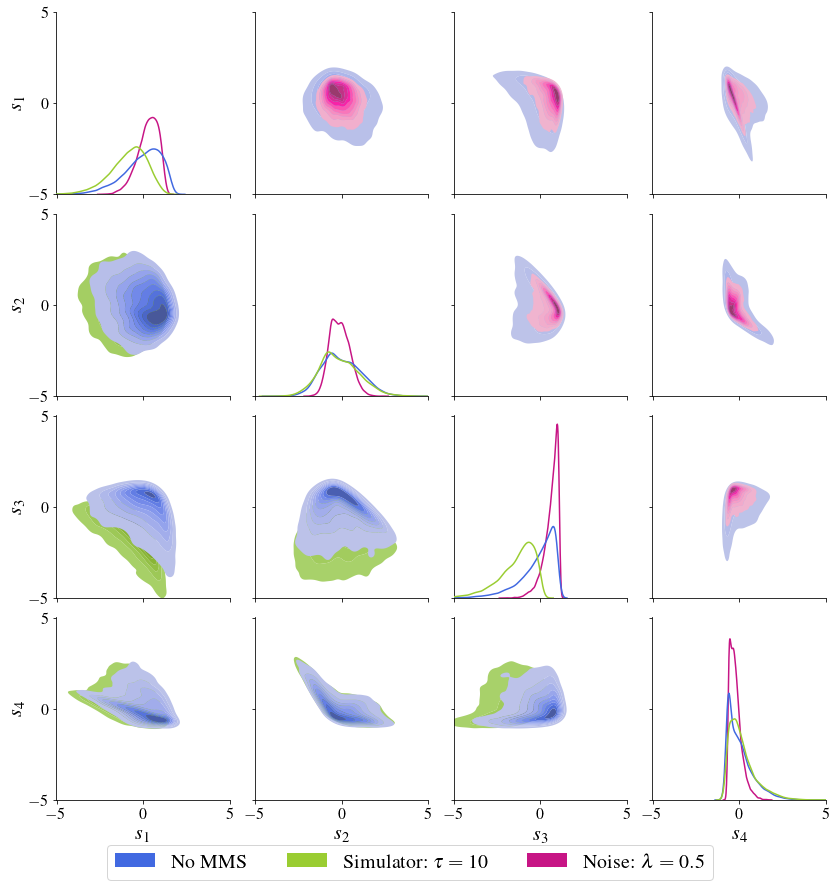

In [34]:
def plot_subset(x, y, hue, mask, **kws):
    sns.kdeplot(x=x[mask], y=y[mask], hue=hue[mask], fill=True, levels=10, antialiased=True, **kws)

g = sns.PairGrid(df, hue="MMS", height=3, palette=[color_codes[task_name] for task_name in TASK_NAMES])

g.map_diag(sns.kdeplot)

g.map_lower(plot_subset, mask= 
            (
                (df["MMS"] == 'Simulator') |
                (df["MMS"] == 'No MMS')
           )
           )


g.map_upper(plot_subset, mask= 
            (
                (df["MMS"] == 'No MMS') |
                (df["MMS"] == 'Noise') 
                
           )
           )

handles = [mpatches.Patch(facecolor=color_codes["No MMS"], label=r"No MMS"),
           mpatches.Patch(facecolor=color_codes["Simulator"], label=r"Simulator: $\tau=10$"),
           mpatches.Patch(facecolor=color_codes["Noise"], label=r"Noise: $\lambda=0.5$")
           ]

plt.legend(handles=handles, loc="upper center", ncol=4, bbox_to_anchor=(-1.4, -1.3), title="", fontsize=20)

absmax = 5.01 #np.ceil(np.abs(df.iloc[:, 1:].values).max())
ticks = np.arange(-100, 100, 5)
ticks = ticks[(ticks>-absmax) & (ticks<absmax)]


for ax in g.axes.flatten():
    ax.set_xlim(-absmax, absmax)
    ax.set_ylim(-absmax, absmax)
    
    ax.set_xticks(ticks)
    ax.set_yticks(ticks)

    
plt.savefig(f"plots/abf_mvn_means_overcomplete_pairplot.{FILEFORMAT}", bbox_inches="tight", dpi=DPI)   ## bbox tight    # tiff oder pdf, dpi > 300

# Wrongness: MMD vs. Posterior Error

## Prior

In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

In [ ]:
def calculate_analytic_posterior(prior, simulator, x):
    n_sim, n_obs, D = x.shape

    # Set up variables
    x_bar = np.mean(x, axis=1)                 # empirical mean
    sigma_0 = np.eye(D) * prior.mu_scale       # mu prior covariance
    sigma_0_inv = np.linalg.inv(sigma_0)       # inverse mu prior covariance
    mu_0 = np.ones((D, 1)) * prior.mu_mean     # mu prior mean
    sigma = simulator.sigma                    # likelihood covariance
    sigma_inv = np.linalg.inv(sigma)           # inverse likelihood covariance

    mu_posterior_covariance = np.stack([np.linalg.inv(sigma_0_inv + n_obs*sigma_inv)] * n_sim)

    mu_posterior_mean = mu_posterior_covariance @ (sigma_0_inv @ mu_0 + n_obs * (sigma_inv @ x_bar[..., np.newaxis]))   
    mu_posterior_mean = mu_posterior_mean.reshape(n_sim, D)

    return mu_posterior_mean, mu_posterior_covariance


In [ ]:
def MMD_error_analysis_prior_MMS(trainer_sufficient, trainer_overcomplete, n_sim=200, n_steps=1000, n_posterior_samples=200):
        
    prior_star = GaussianMeanPrior(D=D, mu_mean=0, mu_scale=1)
    simulator_star = GaussianMeanSimulator(D=D)
    generative_model_star = GenerativeModel(prior_star, simulator_star)
    _, x_star = generative_model_star(n_sim, 100)
    
    s_star_sufficient = trainer_sufficient.network.summary_net(x_star)
    s_star_overcomplete = trainer_overcomplete.network.summary_net(x_star)

    tau_0_min, tau_0_max = 0.0, 2.5
    mu_0_min, mu_0_max = 0.0, 5.0
    b = np.linspace(0, 1, num = n_steps)

    mu_0_list = mu_0_min + b * (mu_0_max - mu_0_min)
    tau_0_list = tau_0_min + b * (tau_0_max - tau_0_min)

    df_sufficient =  pd.DataFrame(
        {'mu_0' : np.zeros(n_steps), 
         'tau_0': np.zeros(n_steps), 
         'MMD': np.zeros(n_steps), 
         'RMSE': np.zeros(n_steps)
        })
    
    df_overcomplete =  pd.DataFrame(
        {'mu_0' : np.zeros(n_steps), 
         'tau_0': np.zeros(n_steps), 
         'MMD': np.zeros(n_steps), 
         'RMSE': np.zeros(n_steps)
        })


    for i in tqdm(range(n_steps)):
        mu_0 = mu_0_list[i]
        tau_0 = tau_0_list[i]
        prior = GaussianMeanPrior(D=D, mu_mean=mu_0, mu_scale=tau_0)
        simulator = GaussianMeanSimulator(D=D)
        generative_model = GenerativeModel(prior, simulator)
        theta = prior(n_sim)
        x = simulator(theta, 100)
        
        s_sufficient = trainer_sufficient.network.summary_net(x)
        s_overcomplete = trainer_overcomplete.network.summary_net(x)

        MMD_sufficient = maximum_mean_discrepancy(s_sufficient, s_star_sufficient, unbiased=True)
        MMD_overcomplete = maximum_mean_discrepancy(s_overcomplete, s_star_overcomplete, unbiased=True)

        theta_est_samples_sufficient = trainer_sufficient.network.sample(x, n_samples=n_posterior_samples)
        theta_est_samples_overcomplete = trainer_overcomplete.network.sample(x, n_samples=n_posterior_samples)

        posterior_mean, posterior_covariance = calculate_analytic_posterior(prior_star, simulator_star, x)
        posterior_sd = np.sqrt(posterior_covariance.diagonal(axis1=1, axis2=2))

        RMSE_sufficient = mean_squared_error(theta_est_samples_sufficient.mean(axis=0), posterior_mean, squared=False)
        RMSE_overcomplete = mean_squared_error(theta_est_samples_overcomplete.mean(axis=0), posterior_mean, squared=False)
        
        df_sufficient.iloc[i, ] = [mu_0, tau_0, MMD_sufficient, RMSE_sufficient]
        df_overcomplete.iloc[i, ] = [mu_0, tau_0, MMD_overcomplete, RMSE_overcomplete]
        
        
    return df_sufficient, df_overcomplete

In [ ]:
df_sufficient_prior, df_overcomplete_prior = MMD_error_analysis_prior_MMS(trainer_sufficient, trainer_overcomplete, n_sim=1000, n_steps=1000, n_posterior_samples=1000)

In [ ]:
df_sufficient_prior.to_pickle("data/MMD_Error/MMD_Error_prior_sufficient.pkl")
df_overcomplete_prior.to_pickle("data/MMD_Error/MMD_Error_prior_overcomplete.pkl")

In [ ]:
df_sufficient_prior

In [ ]:
from mpl_toolkits.axes_grid1 import make_axes_locatable
def moving_average(a, n=3) :
    ret = np.cumsum(a, dtype=float)
    ret[n:] = ret[n:] - ret[:-n]
    return ret[n - 1:] / n

def vectwo(a, b):
    return r"$(\begin{smallmatrix}%.1f\\%.1f\end{smallmatrix})$"%(a, b)

def plot_MMD_error_all_trainers_prior(dfs, names, colors, mode, ylab=r"RMSE($\mu_p\,||\,\mu_{\hat{\theta}})$", lag=5):   
    fig, ax = plt.subplots(figsize=(8,4))
    
    if mode == "x_MMD":
        for df, name, color in zip(dfs, names, colors):
            MMD = np.array(df['MMD'])
            RMSE = np.array(df['RMSE'])

            idx = np.argsort(MMD)

            MMD = MMD[idx]
            RMSE = RMSE[idx]

            ax.plot(MMD, RMSE, alpha=.30, color=color)
            ax.plot(MMD[lag-1:], moving_average(RMSE, n=lag), linewidth=3, color=color, label=name, alpha=1.0) 


        plt.title(f"MMS: {MMS_type}")
        ax.set_xlabel(r"$\widehat{\mathrm{MMD}}^2_u$")
        ax.set_ylabel(ylab)
        ax.set_xlim(0)
        sns.despine()
        ax.grid(alpha=.50)
        ax.legend(fontsize=18)
        
    elif mode == "x_MMS_param":
        
        for df, name, color in zip(dfs, names, colors):
            param_1 = np.array(df.iloc[:, 0])
            param_2 = np.array(df.iloc[:, 1])
            
            MMD = np.array(df['MMD'])
            RMSE = np.array(df['RMSE'])

            idx = np.argsort(MMD)

            MMD = MMD[idx]
            RMSE = RMSE[idx]

            scatterplot = ax.scatter(param_1, RMSE, c=MMD, alpha=.60, cmap='viridis', vmin=0, vmax=9)
            ax.plot(param_1[lag-1:], moving_average(RMSE, n=lag), linewidth=3, color="black", alpha=1.0) 
            ax.annotate(xy=(param_1[-1],moving_average(RMSE, n=lag)[-1]), xytext=(5,0), textcoords='offset points', fontsize=16, text=name, va='center')


        #plt.title(f"MMS: Prior [development note]")
        ax.set_xlabel(r"Prior MMS $(\begin{smallmatrix}\mu_0 \\ \tau_0 \end{smallmatrix})$")
        #ax.set_xlabel(r"$\widehat{\mathrm{MMD}}^2_u$")
        ax.set_ylabel(ylab)
        ax.set_xlim(0)
        ax.set_xticks([0,1,2,3,4,5])
        ax.set_xticklabels([
            r"$(\begin{smallmatrix}0\\ 1 \end{smallmatrix})$",
            "", "", "", "", 
            r"$(\begin{smallmatrix}5\\ 2.5 \end{smallmatrix})$"
        ])
        sns.despine()
        ax.grid(alpha=.50)
        
        divider = make_axes_locatable(ax)
        cax = divider.append_axes("right", size="5%", pad=1.2,)

        cbar = plt.colorbar(scatterplot, cax=cax)
        cbar.ax.set_xlabel(r"$\widehat{\mathrm{MMD}}^2_u$")


    plt.savefig(f"plots/abf_mvn_means_sufficient_vs_overcomplete_MMD_Error_Prior.{FILEFORMAT}", bbox_inches="tight", dpi=DPI)

In [ ]:
if os.path.isfile("data/MMD_Error/MMD_Error_prior_sufficient.pkl"):
    df_sufficient_prior = pd.read_pickle("data/MMD_Error/MMD_Error_prior_sufficient.pkl")
if os.path.isfile("data/MMD_Error/MMD_Error_prior_overcomplete.pkl"):
    df_overcomplete_prior = pd.read_pickle("data/MMD_Error/MMD_Error_prior_overcomplete.pkl")
    
plot_MMD_error_all_trainers_prior(
                            [df_sufficient_prior, df_overcomplete_prior],
                            ['minimal', 'overcomplete'],
                            ['tab:blue', 'tab:red'],
                            mode = "x_MMS_param",
                            lag=20)

In [ ]:
def MMD_error_analysis_noise_likelihood_MMS(trainer_sufficient, trainer_overcomplete, n_sim=200, n_steps=1000, n_posterior_samples=200):
        
    prior_star = GaussianMeanPrior(D=D, mu_mean=0, mu_scale=1)
    simulator_star = GaussianMeanSimulator(D=D)
    generative_model_star = GenerativeModel(prior_star, simulator_star)
    _, x_star = generative_model_star(n_sim, 100)
    
    s_star_sufficient = trainer_sufficient.network.summary_net(x_star)
    s_star_overcomplete = trainer_overcomplete.network.summary_net(x_star)

    tau_min, tau_max = 1.0, 20.0
    lamda_min, lamda_max = 0.0, 1.0
    b = np.linspace(0, 1, num = n_steps)

    lamda_list = lamda_min + b * (lamda_max - lamda_min)
    tau_list = tau_min + b * (tau_max - tau_min)

    df_sufficient =  pd.DataFrame(
        {'lamda' : np.zeros(n_steps), 
         'tau': np.zeros(n_steps), 
         'MMD': np.zeros(n_steps), 
         'RMSE': np.zeros(n_steps)
        })
    
    df_overcomplete =  pd.DataFrame(
        {'lamda' : np.zeros(n_steps), 
         'tau': np.zeros(n_steps), 
         'MMD': np.zeros(n_steps), 
         'RMSE': np.zeros(n_steps)
        })


    for i in tqdm(range(n_steps)):
        lamda = lamda_list[i]
        tau = tau_list[i]
        prior = GaussianMeanPrior(D=D, mu_mean=0, mu_scale=1)
        simulator = GaussianMeanSimulator(D=D, s = tau)
        theta = prior(n_sim)
        x = simulator(theta, 100)
        
        x = noisify_x(x, lamda = lamda,
                      noise_sampler = partial(beta_noise_sampler, a=2, b=5, tau=tau))
        
        s_sufficient = trainer_sufficient.network.summary_net(x)
        s_overcomplete = trainer_overcomplete.network.summary_net(x)

        MMD_sufficient = maximum_mean_discrepancy(s_sufficient, s_star_sufficient, unbiased=True)
        MMD_overcomplete = maximum_mean_discrepancy(s_overcomplete, s_star_overcomplete, unbiased=True)

        theta_est_samples_sufficient = trainer_sufficient.network.sample(x, n_samples=n_posterior_samples)
        theta_est_samples_overcomplete = trainer_overcomplete.network.sample(x, n_samples=n_posterior_samples)

        posterior_mean, posterior_covariance = calculate_analytic_posterior(prior_star, simulator_star, x)
        #posterior_sd = np.sqrt(posterior_covariance.diagonal(axis1=1, axis2=2))

        RMSE_sufficient = mean_squared_error(theta_est_samples_sufficient.mean(axis=0), posterior_mean, squared=False)
        RMSE_overcomplete = mean_squared_error(theta_est_samples_overcomplete.mean(axis=0), posterior_mean, squared=False)
        
        df_sufficient.iloc[i, ] = [lamda, tau, MMD_sufficient, RMSE_sufficient]
        df_overcomplete.iloc[i, ] = [lamda, tau, MMD_overcomplete, RMSE_overcomplete]
        
        
    return df_sufficient, df_overcomplete

In [ ]:
df_sufficient_noise_likelihood, df_overcomplete_noise_likelihood = MMD_error_analysis_noise_likelihood_MMS(trainer_sufficient, trainer_overcomplete, n_sim=200, n_steps=1000, n_posterior_samples=200)


df_sufficient_noise_likelihood.to_pickle("data/MMD_Error/MMD_Error_noise_likelihood_sufficient.pkl")
df_overcomplete_noise_likelihood.to_pickle("data/MMD_Error/MMD_Error_noise_likelihood_overcomplete.pkl")

In [ ]:
np.max(np.array(df_overcomplete_noise_likelihood['MMD']))

In [ ]:
def moving_average(a, n=3) :
    ret = np.cumsum(a, dtype=float)
    ret[n:] = ret[n:] - ret[:-n]
    return ret[n - 1:] / n

In [ ]:
from mpl_toolkits.axes_grid1 import make_axes_locatable



def plot_MMD_error_all_trainers_noise_likelihood(dfs, names, colors, mode, ylab=r"RMSE($\mu_p\,||\,\mu_{\hat{\theta}})$", lag=5):   
    fig, ax = plt.subplots(figsize=(8,4))
    
    if mode == "x_MMD":
        for df, name, color in zip(dfs, names, colors):
            MMD = np.array(df['MMD'])
            RMSE = np.array(df['RMSE'])

            idx = np.argsort(MMD)

            MMD = MMD[idx]
            RMSE = RMSE[idx]

            ax.plot(MMD, RMSE, alpha=.30, color=color)
            ax.plot(MMD[lag-1:], moving_average(RMSE, n=lag), linewidth=3, color=color, label=name, alpha=1.0) 


        plt.title(f"MMS: {MMS_type}")
        ax.set_xlabel(r"$\widehat{\mathrm{MMD}}^2_u$")
        ax.set_ylabel(ylab)
        ax.set_xlim(0)
        sns.despine()
        ax.grid(alpha=.50)
        ax.legend(fontsize=18)
        
    elif mode == "x_MMS_param":
        
        for df, name, color in zip(dfs, names, colors):
            #outlier_idx = np.where(np.array(df['RMSE']) > np.quantile(np.array(df['RMSE']), .95))[0]
            #df = df.drop(outlier_idx)
            
            param_1 = np.array(df.iloc[:, 0])
            param_2 = np.array(df.iloc[:, 1])
            
            MMD = np.array(df['MMD'])
            RMSE = np.array(df['RMSE'])

            idx = np.argsort(MMD)

            MMD = MMD[idx]
            RMSE = RMSE[idx]

            scatterplot = ax.scatter(param_1, RMSE, c=MMD, alpha=.40, cmap='viridis', vmin=0, vmax=9)
            ax.plot(param_1[lag-1:], moving_average(RMSE, n=lag), linewidth=3, color="black", alpha=1.0) 
            ax.annotate(xy=(param_1[-1],moving_average(RMSE, n=lag)[-1]), xytext=(5,0), textcoords='offset points', fontsize=16, text=name, va='center')


        #plt.title(f"MMS: Noise/Likelihood [development note]")
        ax.set_xlabel(r"Noise and Simulator MMS $(\begin{smallmatrix}\lambda \\ \tau \end{smallmatrix})$")
        #ax.set_xlabel(r"$\widehat{\mathrm{MMD}}^2_u$")
        ax.set_ylabel(ylab)
        ax.set_xlim(0)
        ax.set_xticks([0, 0.2, 0.4, 0.6, 0.8, 1.0])
        ax.set_xticklabels([
            r"$(\begin{smallmatrix}0\\ 1 \end{smallmatrix})$",
            "", "", "", "", 
            r"$(\begin{smallmatrix}1\\ 20 \end{smallmatrix})$"
        ])
        sns.despine()
        ax.grid(alpha=.50)
        
        divider = make_axes_locatable(ax)
        cax = divider.append_axes("right", size="5%", pad=1.2)

        cbar = plt.colorbar(scatterplot, cax=cax)
        cbar.ax.set_xlabel(r"$\widehat{\mathrm{MMD}}^2_u$")


    plt.savefig(f"plots/abf_mvn_means_sufficient_vs_overcomplete_MMD_Error_Noise_Likelihood.{FILEFORMAT}", bbox_inches="tight", dpi=DPI)

In [ ]:
if os.path.isfile("data/MMD_Error/MMD_Error_noise_likelihood_sufficient.pkl"):
    df_sufficient_noise_likelihood = pd.read_pickle("data/MMD_Error/MMD_Error_noise_likelihood_sufficient.pkl")
if os.path.isfile("data/MMD_Error/MMD_Error_noise_likelihood_overcomplete.pkl"):
    df_overcomplete_noise_likelihood = pd.read_pickle("data/MMD_Error/MMD_Error_noise_likelihood_overcomplete.pkl")
    

plot_MMD_error_all_trainers_noise_likelihood( 
                            [df_sufficient_noise_likelihood, df_overcomplete_noise_likelihood],
                            ['minimal', 'overcomplete'],
                            ['tab:blue', 'tab:red'],
                            mode="x_MMS_param",
                            lag=20)

In [ ]:
plot_MMD_error_all_trainers_noise_likelihood( 
                            [df_sufficient_noise_likelihood, df_overcomplete_noise_likelihood],
                            ['minimal', 'overcomplete'],
                            ['tab:blue', 'tab:red'],
                            mode="x_MMS_param",
                            lag=10)

In [ ]:
np.mean(RMSE)
np.quantile(RMSE, q = .95)

In [ ]:
fig, axes = plt.subplots(2,1, figsize = (10,10))
ax = axes[0]

ax2 = axes[1]

lag = 20
df = df_sufficient_noise_likelihood
name = "minimal"
ylab = r"RMSE($\mu_p\,||\,\mu_{\hat{\theta}})$"


param_1 = np.array(df.iloc[:, 0])
param_2 = np.array(df.iloc[:, 1])

MMD = np.array(df['MMD'])
RMSE = np.array(df['RMSE'])

idx = np.argsort(MMD)

MMD = MMD[idx]
RMSE = RMSE[idx]

scatterplot = ax.scatter(param_1, RMSE, c=MMD, alpha=.40, cmap='viridis', vmin=0, vmax=0.7)
ax.plot(param_1[lag-1:], moving_average(RMSE, n=lag), linewidth=2, color="black", alpha=1.0) 
ax.annotate(xy=(param_1[-1],moving_average(RMSE, n=lag)[-1]), xytext=(5,0), textcoords='offset points', fontsize=16, text=name, va='center')


ax.set_title(f"MMS: Noise/Likelihood [development note]")
ax.set_xlabel(r"Noise and Simulator MMS $(\begin{smallmatrix}\lambda \\ \tau \end{smallmatrix})$")
#ax.set_xlabel(r"$\widehat{\mathrm{MMD}}^2_u$")
ax.set_ylabel(ylab)
ax.set_xlim(0)
ax.set_xticks([0, 0.2, 0.4, 0.6, 0.8, 1.0])
ax.set_xticklabels([
    r"$(\begin{smallmatrix}0\\ 1 \end{smallmatrix})$",
    "", "", "", "", 
    r"$(\begin{smallmatrix}1\\ 20 \end{smallmatrix})$"
])
sns.despine()
ax.grid(alpha=.50)

ax2.plot(param_1, MMD, linewidth=2, color="black", alpha=1.0) 
ax2.set_xlim(0)
ax2.set_ylabel(r"$\widehat{\mathrm{MMD}}^2_u$")
ax2.set_xticks([0, 0.2, 0.4, 0.6, 0.8, 1.0])
ax2.set_xticklabels([
    r"$(\begin{smallmatrix}0\\ 1 \end{smallmatrix})$",
    "", "", "", "", 
    r"$(\begin{smallmatrix}1\\ 20 \end{smallmatrix})$"
])

#divider = make_axes_locatable(ax)
#cax = divider.append_axes("right", size="5%", pad=1.2)

#cbar = plt.colorbar(scatterplot, cax=cax)
#cbar.ax.set_xlabel(r"$\widehat{\mathrm{MMD}}^2_u$")

In [ ]:
def MMD_error_analysis_noise_MMS(trainer_sufficient, n_sim=200, n_steps=1000, n_posterior_samples=200):
        
    prior_star = GaussianMeanPrior(D=D, mu_mean=0, mu_scale=1)
    simulator_star = GaussianMeanSimulator(D=D)
    generative_model_star = GenerativeModel(prior_star, simulator_star)
    _, x_star = generative_model_star(n_sim, 100)
    
    s_star_sufficient = trainer_sufficient.network.summary_net(x_star)
    #s_star_overcomplete = trainer_overcomplete.network.summary_net(x_star)

    tau_min, tau_max = 1.0, 10.0
    lamda_min, lamda_max = 0.0, 5.0
    b = np.linspace(0, 1, num = n_steps)

    lamda_list = lamda_min + b * (lamda_max - lamda_min)
    tau_list = tau_min + b * (tau_max - tau_min)

    df_sufficient =  pd.DataFrame(
        {'lamda' : np.zeros(n_steps), 
         'tau': np.zeros(n_steps), 
         'MMD': np.zeros(n_steps), 
         'RMSE': np.zeros(n_steps)
        })


    for i in tqdm(range(n_steps)):
        lamda = lamda_list[i]
        tau = 1.0
        #tau = tau_list[i]
        prior = GaussianMeanPrior(D=D, mu_mean=0, mu_scale=1)
        simulator = GaussianMeanSimulator(D=D, s = tau)
        theta = prior(n_sim)
        x = simulator(theta, 100)
        
        x = noisify_x(x, lamda=lamda)
        
        s_sufficient = trainer_sufficient.network.summary_net(x)
        #s_overcomplete = trainer_overcomplete.network.summary_net(x)

        MMD_sufficient = maximum_mean_discrepancy(s_sufficient, s_star_sufficient, unbiased=True)
        #MMD_overcomplete = maximum_mean_discrepancy(s_overcomplete, s_star_overcomplete, unbiased=True)

        theta_est_samples_sufficient = trainer_sufficient.network.sample(x, n_samples=n_posterior_samples)
        #theta_est_samples_overcomplete = trainer_overcomplete.network.sample(x, n_samples=n_posterior_samples)

        posterior_mean, posterior_covariance = calculate_analytic_posterior(prior_star, simulator_star, x)
        posterior_sd = np.sqrt(posterior_covariance.diagonal(axis1=1, axis2=2))

        RMSE_sufficient = mean_squared_error(theta_est_samples_sufficient.mean(axis=0), posterior_mean, squared=False)
        #RMSE_overcomplete = mean_squared_error(theta_est_samples_overcomplete.mean(axis=0), posterior_mean, squared=False)
        
        df_sufficient.iloc[i, ] = [lamda, tau, MMD_sufficient, RMSE_sufficient]
        #df_overcomplete.iloc[i, ] = [lamda, tau, MMD_overcomplete, RMSE_overcomplete]
        
        
    return df_sufficient#, df_overcomplete

In [ ]:
df_sufficient_noise = MMD_error_analysis_noise_MMS(trainer_sufficient, n_sim=200, n_steps=200, n_posterior_samples=200)

In [ ]:
def MMD_error_analysis_likelihood_MMS(trainer_sufficient, n_sim=200, n_steps=1000, n_posterior_samples=200):
        
    prior_star = GaussianMeanPrior(D=D, mu_mean=0, mu_scale=1)
    simulator_star = GaussianMeanSimulator(D=D)
    generative_model_star = GenerativeModel(prior_star, simulator_star)
    _, x_star = generative_model_star(n_sim, 100)
    
    s_star_sufficient = trainer_sufficient.network.summary_net(x_star)
    #s_star_overcomplete = trainer_overcomplete.network.summary_net(x_star)

    tau_min, tau_max = 1.0, 10.0
    lamda_min, lamda_max = 0.0, 5.0
    b = np.linspace(0, 1, num = n_steps)

    lamda_list = lamda_min + b * (lamda_max - lamda_min)
    tau_list = tau_min + b * (tau_max - tau_min)

    df_sufficient =  pd.DataFrame(
        {'lamda' : np.zeros(n_steps), 
         'tau': np.zeros(n_steps), 
         'MMD': np.zeros(n_steps), 
         'RMSE': np.zeros(n_steps)
        })


    for i in tqdm(range(n_steps)):
        #lamda = lamda_list[i]
        lamda = 0.0
        tau = tau_list[i]
        prior = GaussianMeanPrior(D=D, mu_mean=0, mu_scale=1)
        simulator = GaussianMeanSimulator(D=D, s = tau)
        theta = prior(n_sim)
        x = simulator(theta, 100)
        
        x = noisify_x(x, lamda=lamda)
        
        s_sufficient = trainer_sufficient.network.summary_net(x)
        #s_overcomplete = trainer_overcomplete.network.summary_net(x)

        MMD_sufficient = maximum_mean_discrepancy(s_sufficient, s_star_sufficient, unbiased=True)
        #MMD_overcomplete = maximum_mean_discrepancy(s_overcomplete, s_star_overcomplete, unbiased=True)

        theta_est_samples_sufficient = trainer_sufficient.network.sample(x, n_samples=n_posterior_samples)
        #theta_est_samples_overcomplete = trainer_overcomplete.network.sample(x, n_samples=n_posterior_samples)

        posterior_mean, posterior_covariance = calculate_analytic_posterior(prior_star, simulator_star, x)
        posterior_sd = np.sqrt(posterior_covariance.diagonal(axis1=1, axis2=2))

        RMSE_sufficient = mean_squared_error(theta_est_samples_sufficient.mean(axis=0), posterior_mean, squared=False)
        #RMSE_overcomplete = mean_squared_error(theta_est_samples_overcomplete.mean(axis=0), posterior_mean, squared=False)
        
        df_sufficient.iloc[i, ] = [lamda, tau, MMD_sufficient, RMSE_sufficient]
        #df_overcomplete.iloc[i, ] = [lamda, tau, MMD_overcomplete, RMSE_overcomplete]
        
        
    return df_sufficient#, df_overcomplete

In [ ]:
df_sufficient_likelihood = MMD_error_analysis_likelihood_MMS(trainer_sufficient, n_sim=200, n_steps=200, n_posterior_samples=200)

In [ ]:
fig, axes = plt.subplots(2,1, figsize = (10,10))
ax = axes[0]

ax2 = axes[1]

lag = 20
df = df_sufficient_noise
name = "minimal"
ylab = r"RMSE($\mu_p\,||\,\mu_{\hat{\theta}})$"


param_1 = np.array(df.iloc[:, 0])

MMD = np.array(df['MMD'])
RMSE = np.array(df['RMSE'])

idx = np.argsort(MMD)

MMD = MMD[idx]
RMSE = RMSE[idx]

scatterplot = ax.scatter(param_1, RMSE, c=MMD, alpha=.40, cmap='viridis', vmin=0, vmax=5)
ax.plot(param_1[lag-1:], moving_average(RMSE, n=lag), linewidth=2, color="black", alpha=1.0) 
ax.annotate(xy=(param_1[-1],moving_average(RMSE, n=lag)[-1]), xytext=(5,0), textcoords='offset points', fontsize=16, text=name, va='center')


ax.set_title(f"MMS: Noise/Likelihood [development note]")
ax.set_xlabel(r"Noise MMS $\lambda$")
#ax.set_xlabel(r"$\widehat{\mathrm{MMD}}^2_u$")
ax.set_ylabel(ylab)
sns.despine()
ax.grid(alpha=.50)

ax2.plot(param_1, MMD, linewidth=2, color="black", alpha=1.0) 
ax2.set_xlim(0)
ax2.set_ylabel(r"$\widehat{\mathrm{MMD}}^2_u$")
ax2.set_xlabel(r"Noise MMS $\lambda$")


#divider = make_axes_locatable(ax)
#cax = divider.append_axes("right", size="5%", pad=1.2)

#cbar = plt.colorbar(scatterplot, cax=cax)
#cbar.ax.set_xlabel(r"$\widehat{\mathrm{MMD}}^2_u$")

In [ ]:
df_sufficient_noise

In [ ]:
fig, axes = plt.subplots(2,1, figsize = (10,10))
ax = axes[0]

ax2 = axes[1]

lag = 20
df = df_sufficient_likelihood
name = "minimal"
ylab = r"RMSE($\mu_p\,||\,\mu_{\hat{\theta}})$"


param_1 = np.array(df.iloc[:, 1])

MMD = np.array(df['MMD'])
RMSE = np.array(df['RMSE'])

idx = np.argsort(MMD)

MMD = MMD[idx]
RMSE = RMSE[idx]

scatterplot = ax.scatter(param_1, RMSE, c=MMD, alpha=.40, cmap='viridis', vmin=0, vmax=5)
ax.plot(param_1[lag-1:], moving_average(RMSE, n=lag), linewidth=2, color="black", alpha=1.0) 
ax.annotate(xy=(param_1[-1],moving_average(RMSE, n=lag)[-1]), xytext=(5,0), textcoords='offset points', fontsize=16, text=name, va='center')


ax.set_title(f"MMS: Noise/Likelihood [development note]")
ax.set_xlabel(r"Likelihood MMS $\tau$")
#ax.set_xlabel(r"$\widehat{\mathrm{MMD}}^2_u$")
ax.set_ylabel(ylab)
sns.despine()
ax.grid(alpha=.50)

ax2.plot(param_1, MMD, linewidth=2, color="black", alpha=1.0) 
ax2.set_xlim(0)
ax2.set_ylabel(r"$\widehat{\mathrm{MMD}}^2_u$")
ax2.set_xlabel(r"Likelihood MMS $\tau$")


#divider = make_axes_locatable(ax)
#cax = divider.append_axes("right", size="5%", pad=1.2)

#cbar = plt.colorbar(scatterplot, cax=cax)
#cbar.ax.set_xlabel(r"$\widehat{\mathrm{MMD}}^2_u$")

In [ ]:

tau_min, tau_max = 1.0, 10.0
lamda_min, lamda_max = 0.0, 1.0

n_tau = 10
n_lamda = 10

tau_list = np.linspace(tau_min, tau_max, num=n_tau)
lamda_list = np.linspace(lamda_min, lamda_max, num=n_lamda)

fig, axes = plt.subplots(n_tau, n_lamda, figsize=(25, 25))
nrows, ncols = axes.shape
for row in range(nrows):
    for col in range(ncols):
        tau = tau_list[row]
        lamda = lamda_list[col]
        ax = axes[row, col]
        ax.set_ylabel("")
        ax.set_yticks([])
        ax.set_xlim(-20, 20)
        ax.set_title(r"$\lambda=%.1f, \tau=%.1f$"%(lamda, tau))
        for _ in range(3):
            theta, x = trainer_sufficient._forward_inference(1, 500)
            prior = GaussianMeanPrior(D=D, mu_mean=0, mu_scale=1)
            simulator = GaussianMeanSimulator(D=D, s = tau)
            theta = prior(n_sim)
            x = simulator(theta, 100)
            x = noisify_x(x, lamda = lamda,
                          noise_sampler = partial(beta_noise_sampler, a=2, b=5, tau=tau)
                         )
            x = x[0, :, 0]
            sns.kdeplot(x, ax=ax, alpha=.40)
        
sns.despine()
fig.tight_layout()
plt.savefig("plots/abf_mvn_data_noise_likelihood.jpg", bbox_inches="tight")